In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import sympy as sp
import numpy as np
import control as ctl

# EXTRAINDO OS DADOS

In [3]:
df = pd.read_csv('DataBase.csv')
df = df[['time', 'theta', 'distance']]
df

,time,theta,distance
0,0.00,100,3.69
1,0.00,100,3.67
2,0.01,100,3.69
3,0.01,100,3.69
4,0.01,100,3.67
...,...,...,...
269,4.94,100,19.72
270,4.96,100,19.72
271,4.98,100,19.72
272,5.00,100,19.74


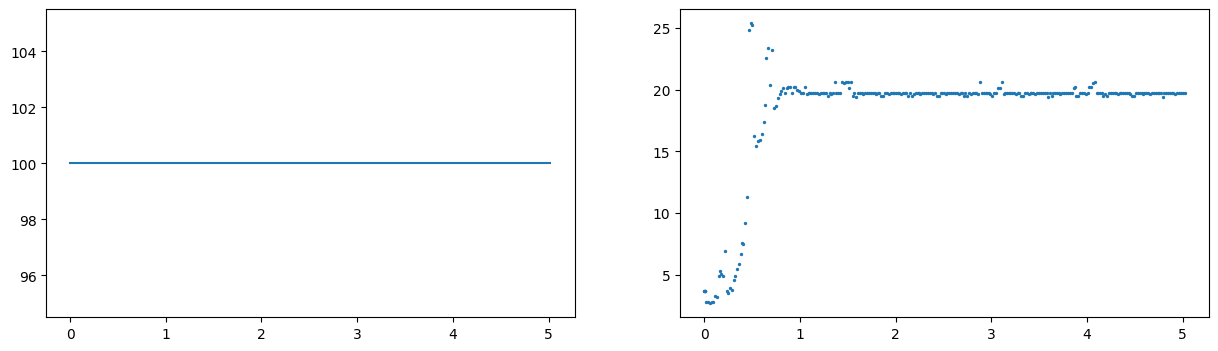

In [4]:
plt.figure(figsize=(15, 4))

plt.subplot(1, 2, 1)
plt.plot(df['time'], df['theta'])

plt.subplot(1, 2, 2)
plt.scatter(df['time'], df['distance'], s=2)

# FILTRANDO OS DADOS

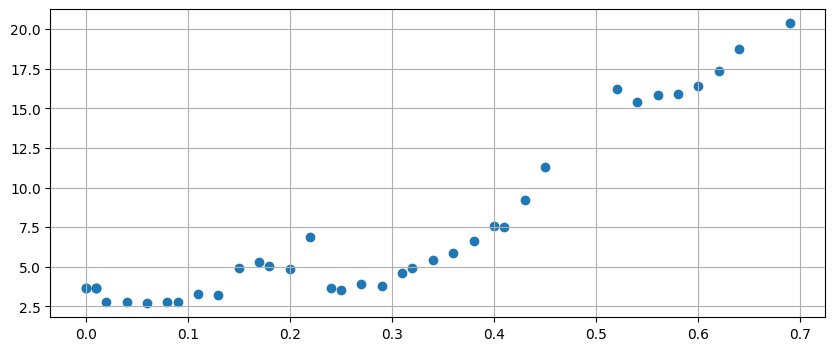

In [5]:
df = df.loc[df['distance'] < 22]
df = df.loc[df['distance'] > 2.5]
df = df.loc[df['time'] < 0.7]

plt.figure(figsize=(10, 4))
plt.scatter(df['time'], df['distance'])
plt.grid()
plt.show()

## FREQUÊNCIA DE AMOSTRAGEM
- Os dados precisam ter uma frequência de amostragem constante

In [6]:
def normalizeData(time, response, T=0.01):
    timeIntervals = np.arange(np.min(time), np.max(response), T)
    tData = []
    yData = []

    for i in range(len(timeIntervals) - 1):
        position      = timeIntervals[i]
        next_position = timeIntervals[i + 1]

        target = response[(time > position) & (time <= next_position)]
        
        if len(target) == 0:
            continue
        
        t = (next_position + position)/2
        y = np.min(target)

        tData.append(t)
        yData.append(y)

    return tData, yData

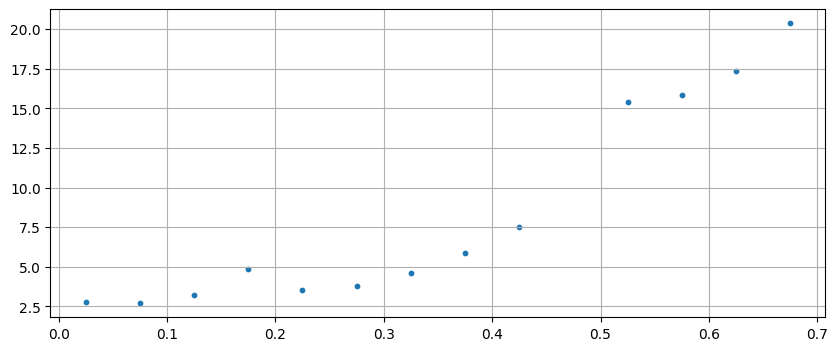

In [7]:
time     = df['time'].to_numpy()
response = df['distance'].to_numpy()
tData, yData = normalizeData(time, response, T=0.05)

plt.figure(figsize=(10, 4))
plt.scatter(tData, yData, s=10)
plt.grid()
plt.show()

# DATA FITTING
O gráfico expressa a função de transferência no domínio do tempo $Y(s) = L^{-1}\{y(t)\}$, podemos encontrar $y(t)$ usando data fitting, encontrando uma função própria que se encaixe nos dados

In [8]:
# Função para uso com curve_fit (NumPy)
def f(t, a, b, c):
    return a*t*np.exp(b*t) + c

# Função para representação simbólica (SymPy)
def f_sp(t, a, b, c):
    return a*t*sp.exp(b*t) + c

def getFunction(xDados, yDados):
    coeficientes = curve_fit(f, xDados, yDados, maxfev=1000000000)  # MÁXIMO DE ITERAÇÕES
    return list(coeficientes[0])

def sympyFunction(tf):
    num, den = ctl.tfdata(tf)
    s = sp.var('s')
    num_expr = sum(coef*s**i for i, coef in enumerate(num[0][0][::-1]))
    den_expr = sum(coef*s**i for i, coef in enumerate(den[0][0][::-1]))
    sympy_system = num_expr/den_expr
    return sympy_system

def roundSympyFunction(expr, num_digits=8):
    return expr.xreplace({n: round(n, num_digits) for n in expr.atoms(sp.Float)})

In [9]:
coefs = getFunction(tData, yData)  
f_sp = roundSympyFunction(f_sp(sp.var('t'), *coefs))
f_sp

5.15825572*t*exp(2.5350536*t) + 2.06708134

### VALIDAÇÃO
Vemos que realmente bate com a função que encontramos apenas pelo gráfico de pontos

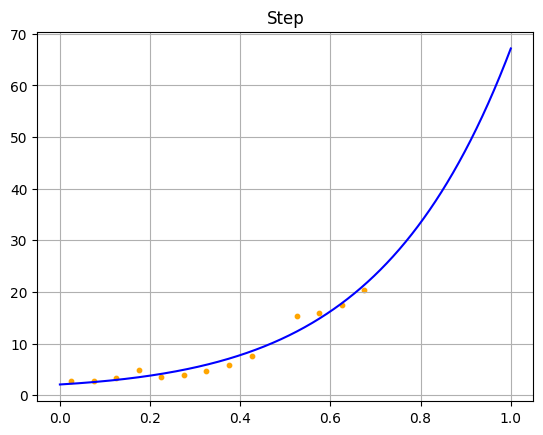

In [10]:
time     = np.linspace(0, 1, 1000)
response = f(time, *coefs)

plt.scatter(tData, yData, color='orange', s=10)
plt.plot(time, response, color='blue')
plt.title('Step')
plt.grid()
plt.show()

# ENCONTRANDO $G(s)$
- Agora que temos a resposta no tempo em uma função contínua, basta laplaceá-la para encontrar a função de transferência do sistema

In [11]:
def transformadaLaplace(function):   
    t, s = sp.symbols('t s')
    return sp.laplace_transform(function, t, s)[0].expand().simplify()

def transformadaInversaLaplace(function):   
    t, s = sp.symbols('t s')
    return sp.inverse_laplace_transform(function, s, t).expand().simplify()

Y = transformadaLaplace(f_sp)
Y = roundSympyFunction(Y)
Y

(0.32164979*s**2 - 0.82814455*s + 2.06708134)/(s*(0.15560577*s**2 - 0.78893795*s + 1))

- O degrau aplicado $r$ foi a entrada do sistema, permaneceu constante durante todo o processo

In [12]:
r = df['theta'].mean()
r

100.0

- $R(s) = L\{r(t)\}$

In [13]:
R = transformadaLaplace(r)
R

100.0/s

- A função de transferência é a razão da saída pela entrada, ou seja, $G(s) = \frac{Y(s)}{R(s)}$ 

In [14]:
G = (Y/R).factor()
s = ctl.TransferFunction.s

G = eval(str(G))
G

TransferFunction(array([ 0.0032165 , -0.00828145,  0.02067081]), array([ 0.15560577, -0.78893795,  1.        ]))

# DANDO UM STEP E VALIDANDO

In [15]:
stop_time = 1

In [16]:
df = pd.read_csv('DataBase.csv')
df = df[['time', 'theta', 'distance']]
df = df.loc[df['time'] < stop_time]

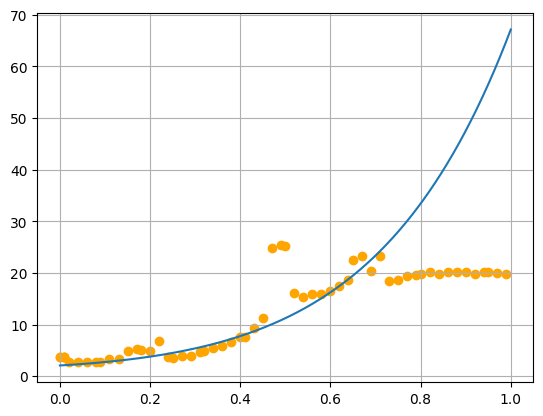

In [17]:
T = np.linspace(0, stop_time, 1000)
U = r * np.ones(1000)
time, response = ctl.forced_response(G, T=T, U=U)

plt.plot(time, response)
plt.scatter(df['time'], df['distance'], color='orange')

plt.grid()
plt.show()

In [18]:
print(sympyFunction(G))
G

(0.00321649789783711*s**2 - 0.00828144549783228*s + 0.0206708134012297)/(0.15560577*s**2 - 0.78893795*s + 1.0)


TransferFunction(array([ 0.0032165 , -0.00828145,  0.02067081]), array([ 0.15560577, -0.78893795,  1.        ]))

# APROXIMAÇÃO PARA SEGUNDA ORDEM
- A ideia da aproximação para uma função de transferência de segunda ordem é usar os polos dominantes da função de transferência original e ajustar o ganho do numerador até se obter a melhor aproximação possível

In [25]:
G2 = ctl.TransferFunction(1, G.den[0][0])
G2

TransferFunction(array([1]), array([ 0.15560577, -0.78893795,  1.        ]))

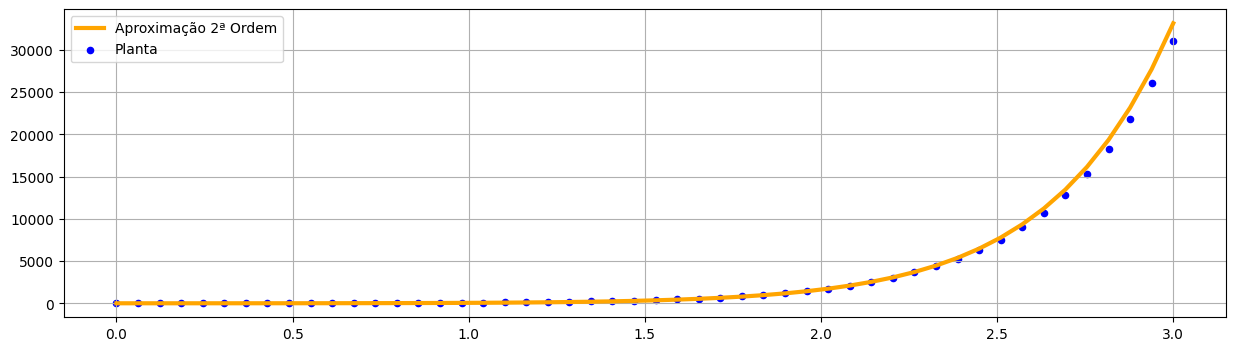

In [27]:
stop_time = 3
T = np.linspace(0, stop_time, 50)
U = r * np.ones(len(T))
plt.figure(figsize=(15, 4))

K = .025
time, response = ctl.forced_response(K*G2, T=T, U=U)
plt.plot(time, response, label='Aproximação 2ª Ordem', linewidth=3, color='orange')

time, response = ctl.forced_response(G, T=T, U=U)
plt.scatter(time, response, label='Planta', color='blue', s=20)

plt.legend()
plt.grid()
plt.show()

In [28]:
print(sympyFunction(K*G2))
K*G2

0.025/(0.15560577*s**2 - 0.78893795*s + 1.0)


TransferFunction(array([0.025]), array([ 0.15560577, -0.78893795,  1.        ]))